In [99]:
import os
import numpy as np
import pandas as pd
import obspy.taup as taup
import matplotlib.pyplot as plt
from obspy.taup.taup_create import build_taup_model
from collections import namedtuple
from scipy.stats import norm
from loc1sta.epicentral_distance import get_sp_time_differences_and_angles, save_sp_time_differences_and_angles, load_sp_time_differences_and_angles, get_distances_and_angles_as_function_of_depth_from_model_data
from loc1sta.epicentral_distance import get_distances_from_sp_times
from loc1sta.epicentral_distance import get_location_from_sta_dist_km_azimuth

RECALC_MODEL = False

DATA_DIR = 'data'

## Earth models to compare

In [76]:
if RECALC_MODEL:
    MIN_DEG = 0.0
    MAX_DEG = 0.5

    m_iasp = taup.TauPyModel("iasp91")
    m_ak135 = taup.TauPyModel("ak135")

    # build_taup_model(filename=os.path.join(DATA_DIR, "west_caspian_model.tvel"))
    # m_west_caspian = taup.TauPyModel("west_caspian_model")

    build_taup_model(filename=os.path.join(DATA_DIR, "lower_kura_model.tvel"))
    m_lower_kura = taup.TauPyModel("lower_kura_model")


Building obspy.taup model for 'data/lower_kura_model.tvel' ...


## Compare the S-P times against distance for the models

In [77]:
if RECALC_MODEL:
    source_depth_km = 13.0
    # dist_deg, sp_times_iasp, angles_iasp = get_sp_time_differences_and_plunges(m_iasp, MIN_DEG, MAX_DEG, source_depth_km)
    dist_deg, sp_times_ak135, angles_ak135, takeoff_ak135 = get_sp_time_differences_and_angles(m_ak135, MIN_DEG, MAX_DEG, source_depth_km)
    #dist_deg, sp_times_west_caspian, angles_west_caspian = get_sp_time_differences_and_incident_angles(m_west_caspian, MIN_DEG, MAX_DEG, source_depth_km)
    dist_deg, sp_times_lower_kura, angles_lower_kura, takeoff_lower_kura = get_sp_time_differences_and_angles(m_lower_kura, MIN_DEG, MAX_DEG, source_depth_km)

    dist_km = dist_deg * 111.25

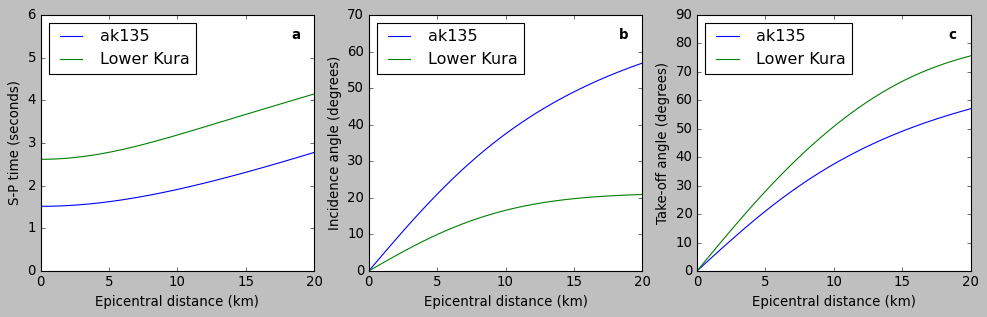

In [79]:
if RECALC_MODEL:
    figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

    ax = axes[0]
    plt.sca(ax)
    # plt.plot(dist_km, sp_times_iasp, label="iasp91")
    plt.plot(dist_km, sp_times_ak135, label="ak135")
    # plt.plot(dist_km, sp_times_west_caspian, label='west_caspian')
    plt.plot(dist_km, sp_times_lower_kura, label='Lower Kura')
    plt.xlim(0, 20)
    plt.ylim(0, 6)
    plt.ylabel('S-P time (seconds)')
    plt.xlabel('Epicentral distance (km)')
    plt.legend(loc='upper left')
    plt.text(.95, .95, 'a', weight='bold', ha='right', va='top', transform=ax.transAxes)


    ax = axes[1]
    plt.sca(ax)
    # plt.plot(dist_km, plunges_iasp, label="iasp91")
    plt.plot(dist_km, 90-(90-angles_ak135), label="ak135")
    # plt.plot(dist_km, 90-angles_west_caspian, label='west_caspian')
    plt.plot(dist_km, 90-(90-angles_lower_kura), label='Lower Kura')
    plt.xlim(0, 20)
    plt.ylim(0, 70)
    plt.ylabel('Incidence angle (degrees)')
    plt.xlabel('Epicentral distance (km)')
    plt.legend(loc='upper left')
    plt.text(.95, .95, 'b', weight='bold', ha='right', va='top', transform=ax.transAxes)


    ax = axes[2]
    plt.sca(ax)
    # plt.plot(dist_km, plunges_iasp, label="iasp91")
    plt.plot(dist_km, 90-(takeoff_ak135-90), label="ak135")
    # plt.plot(dist_km, 90-angles_west_caspian, label='west_caspian')
    plt.plot(dist_km, 90-(takeoff_lower_kura-90), label='Lower Kura')
    plt.xlim(0, 20)
    plt.ylim(0, 90)
    plt.ylabel('Take-off angle (degrees)')
    plt.xlabel('Epicentral distance (km)')
    plt.legend(loc='upper left')
    plt.text(.95, .95, 'c', weight='bold', ha='right', va='top', transform=ax.transAxes)

    plt.savefig('figures/compare_sp_times_for_all_models_depth_13.png')
    plt.show()

## Extract epicentral parameters as a function of source depth for the Lower Kura model

In [67]:
if RECALC_MODEL:
    MIN_DEPTH = 0
    MAX_DEPTH = 8
    N_DEPTH = 2 * (MAX_DEPTH-MIN_DEPTH) + 1
    source_depths = np.linspace(MIN_DEPTH, MAX_DEPTH, N_DEPTH)

In [68]:
if RECALC_MODEL:
    for source_depth_km in source_depths:
        dist_deg, sp_times_lower_kura, p_angles, t_angles = get_sp_time_differences_and_angles(m_lower_kura, MIN_DEG, MAX_DEG, source_depth_km)
        save_sp_time_differences_and_angles(distances_deg=dist_deg, sp_times=sp_times_lower_kura, incident_angles=p_angles, takeoff_angles=t_angles, source_depth=source_depth_km, dirname=DATA_DIR, basename='lower_kura')

## Load epicentral parameter files

In [69]:
df_dict = load_sp_time_differences_and_angles(dirname=DATA_DIR, basename='lower_kura')
print(df_dict.keys())

dict_keys([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0])


## Extract parameters for a measured s-p time

In [70]:
Cluster = namedtuple('Cluster', ['index', 'min_incidence', 'max_incidence', 'sp_time'])

cluster_measurements = {}
# here are Zaur's clusters and measurements
cluster_measurements[8] = Cluster(index=8, min_incidence=13.0, max_incidence=13.0, sp_time=2.80)
cluster_measurements[9] = Cluster(index=9, min_incidence=12.0, max_incidence=12.0, sp_time=2.80)
cluster_measurements[11] = Cluster(index=11, min_incidence=12.0, max_incidence=12.0, sp_time=3.00)
cluster_measurements[12] = Cluster(index=12, min_incidence=9.0, max_incidence=12.0, sp_time=2.77)
cluster_measurements[14] = Cluster(index=14, min_incidence=10.0, max_incidence=12.0, sp_time=2.74)
cluster_measurements[15] = Cluster(index=15, min_incidence=10.0, max_incidence=10.0, sp_time=3.00)

In [91]:
def plot_depths_distances_angles(depths, dist_km, angles, t_angles, sp_time):
    plt.style.use('classic')
    figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    plt.sca(axes[0])
    ax = plt.gca()
    plt.plot(angles, depths, color='k')
    plt.xlabel('Incidence angle (degrees)')
    plt.ylabel('Source depth (km)')
    plt.xlim(0, 14)
    plt.ylim(10, 20)
    plt.text(.95, .95, 'a', weight='bold', ha='right', va='top', transform=ax.transAxes)

    plt.sca(axes[1])
    ax = plt.gca()

    plt.plot(angles, dist_km, color='k')
    plt.xlabel('Incidence angle (degrees)')
    plt.ylabel('Epicentral distance (km)')
    plt.xlim(0, 14)
    plt.ylim(0, 8)
    plt.text(.95, .95, 'b', weight='bold', ha='right', va='top', transform=ax.transAxes)

    plt.sca(axes[2])
    ax = plt.gca()
    plt.plot(angles, 90-(np.array(t_angles)-90), color='k')
    plt.xlabel('Incidence angle (degrees)')
    plt.ylabel('Takeoff angle (degrees)')
    plt.xlim(0, 14)
    plt.ylim(0, 45)
    plt.text(.95, .95, 'c', weight='bold', ha='right', va='top', transform=ax.transAxes)

    plt.suptitle(f'S-P time {sp_time}s')
    plt.savefig(f'figures/epicentral_dist_vs_source_depth_sp_time_{sp_time}s.png')

In [121]:
# tribe 1
sp_times = [2.57, 2.89, 2.70, 2.80, 2.84, 2.81, 2.77, 2.75, 3.14, 3.09, 3.01, 3.12, 3.44, 3.17, 3.19, 2.88]
i_angles = [4.6, 4.2, 6.5, 4.0, 8.0, 5.7, 6.8, 6.1, 9.9, 9.7, 7.2, 8.9, 9.3, 11.0, 12.9, 7.1]
i_unc = [2.6, 3.3, 3.9, 4.6, 6.0, 3.5, 5.0, 3.6, 5.7, 6.1, 4.7, 4.9, 4.4, 5.9, 6.2, 4.8]

# tribe 2
sp_times = [2.74, 1.64, 1.52, 3.51, 0.6, 0.97, 3.03, 0.9, 1.77, 1.56, 0.94, 0.54, 2.06, 0.82, 1.24, 2.46, 1.22, 1.0, 0.72]
i_angles = [23.42, 38.81, 17.07, 18.8, 29.62, 14.52, 20.39, 9.89, 13.17, 27.28, 17.11, 15.46, 16.23, 38.97, 38.89, 11.21, 6.54, 13.72, 18.8, 6.81]
i_unc = [10.22, 10.64, 7.87, 9.23, 10.85, 7.34, 8.58, 5.32, 7.1, 9.94, 8.18, 7.56, 7.14, 10.42, 10.69, 5.56, 3.94, 7.15, 8.95, 4.26]

# az 225 both tribes

sp_times = [2.57, 2.89, 2.70, 2.80, 2.84, 2.81, 2.77, 2.75, 3.14, 3.09, 3.01, 3.12, 3.44, 3.17, 3.19, 2.88, 2.74, 1.64, 1.52, 0.6, 0.97, 3.03, 0.9, 1.77, 1.56, 0.54, 2.06, 0.82, 1.24, 2.46, 1.0, 0.72]
i_angles = [4.6, 4.2, 6.5, 4.0, 8.0, 5.7, 6.8, 6.1, 9.9, 9.7, 7.2, 8.9, 9.3, 11.0, 12.9, 7.1, 23.42, 38.81, 17.07, 29.62, 14.52, 20.39, 9.89, 13.17, 27.28, 15.46, 16.23, 38.97, 38.89, 11.21, 6.54, 18.8, 6.81]
i_unc = [2.6, 3.3, 3.9, 4.6, 6.0, 3.5, 5.0, 3.6, 5.7, 6.1, 4.7, 4.9, 4.4, 5.9, 6.2, 4.8, 10.22, 10.64, 7.87, 10.85, 7.34, 8.58, 5.32, 7.1, 9.94, 7.56, 7.14, 10.42, 10.69, 5.56, 3.94, 8.95, 4.26]

df = pd.DataFrame(list(zip(sp_times, i_angles, i_unc)), columns=['SP_Time', 'i_angle', 'i_unc'])

n_events = len(df)
N_SAMPLES = 1000
ev_depths = []
ev_depths_unc = []
ev_dists = []
ev_dists_unc = []
ev_tangles = []
ev_tangles_unc = []
for i in range(n_events):
    sp_time = sp_times[i]
    i_angle = i_angles[i]
    i_un = i_unc[i]
    i_samples = norm(i_angle, i_un).rvs(N_SAMPLES)

    depths, dist_km, angles, t_angles = get_distances_and_angles_as_function_of_depth_from_model_data(df_dict, sp_time)
    # plot_depths_distances_angles(depths, dist_km, angles, t_angles, sp_time)

    # sort angles in ascending order
    idx = np.argsort(angles)
    angles_sorted = np.array(angles)[idx]
    depths_sorted = np.array(depths)[idx]
    dist_km_sorted = np.array(dist_km)[idx]
    t_angles_sorted = np.array(t_angles)[idx]
    # use the central value to get the central value
    my_depth = np.interp(i_angle, angles_sorted, depths_sorted)
    my_dist = np.interp(i_angle, angles_sorted, dist_km_sorted)
    my_t_angle = np.interp(i_angle, angles_sorted, t_angles_sorted)
    ev_depths.append(my_depth)
    ev_dists.append(my_dist)
    ev_tangles.append(my_t_angle)

    # use the samples to get a rough estimate of the uncertainty
    my_depths = np.interp(i_samples, angles_sorted, depths_sorted)
    my_dists = np.interp(i_samples, angles_sorted, dist_km_sorted)
    my_t_angles = np.interp(i_samples, angles_sorted, t_angles_sorted)
    ev_depths_unc.append(np.std(my_depths))
    ev_dists_unc.append(np.std(my_depths))
    ev_tangles_unc.append(np.std(my_t_angles))

df['Depth_km'] = ev_depths
df['Depth_unc'] = ev_depths_unc
df['Dist_km'] = ev_dists
df['Dist_unc'] = ev_dists_unc
df['T-angle'] = ev_tangles
df['T-angle_unc'] = ev_tangles_unc
df['T-angle-upper'] = 180 - df['T-angle']

print(df)

    SP_Time  i_angle  i_unc   Depth_km  Depth_unc   Dist_km  Dist_unc  \
0      2.57     4.60   2.60  12.097341   1.383383  1.968878  1.383383   
1      2.89     4.20   3.30  15.619135   1.600656  2.495672  1.600656   
2      2.70     6.50   3.90  13.144461   2.355385  3.165333  2.355385   
3      2.80     4.00   4.60  15.407355   2.618798  2.189142  2.618798   
4      2.84     8.00   6.00  14.168602   2.611473  4.382000  2.611473   
5      2.81     5.70   3.50  14.439427   1.596681  3.121664  1.596681   
6      2.77     6.80   5.00  13.782750   2.392906  3.539130  2.392906   
7      2.75     6.10   3.60  13.730013   2.139986  3.136108  2.139986   
8      3.14     9.90   5.70  16.143317   2.459910  6.707373  2.459910   
9      3.09     9.70   6.10  15.862775   2.556660  6.366320  2.556660   
10     3.01     7.20   4.70  15.945981   1.801352  4.582225  1.801352   
11     3.12     8.90   4.90  16.311784   1.916493  6.012659  1.916493   
12     3.44     9.30   4.40  18.450446   1.794052  

In [122]:
#df.round(1).to_csv('data/highHZ_HASN_good_locations.txt', index=False, sep=' ')
# df.round(1).to_csv('data/HASN_tribe2_good_locations.txt', index=False, sep=' ')
df.round(1).to_csv('data/HASN_both_225_good_locations.txt', index=False, sep=' ')


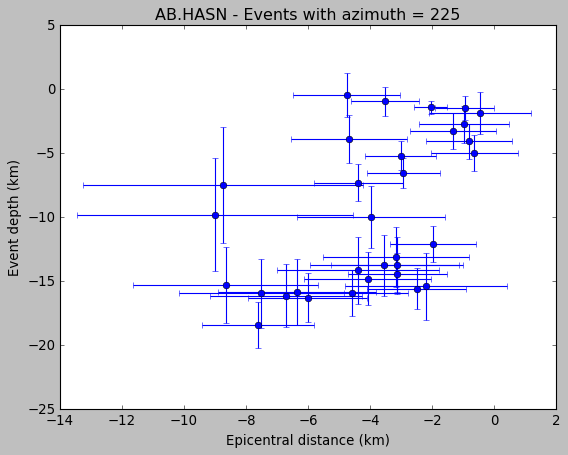

In [125]:
plt.errorbar(-df['Dist_km'], -df['Depth_km'], xerr=df['Dist_unc'], yerr=df['Depth_unc'], marker='o', linestyle='none')
plt.xlabel('Epicentral distance (km)')
plt.ylabel('Event depth (km)')
#plt.savefig('figures/tribe1-depth-vs-dist.png')
# plt.savefig('figures/tribe2-depth-vs-dist.png')
plt.title('AB.HASN - Events with azimuth = 225')
plt.savefig('figures/tribes-both-225-depth-vs-dist.png')


In [12]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']